## Solving wave equation in Python

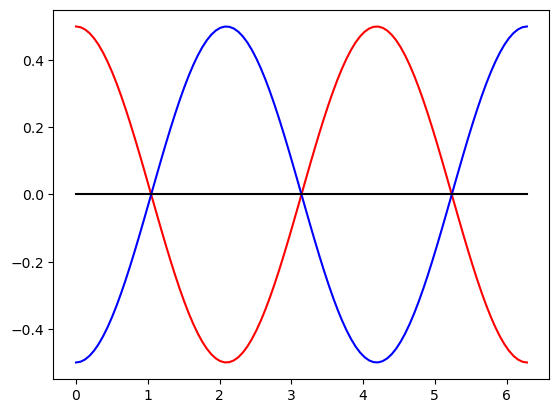

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

xmin  = 0                                    # --- Left boundary of the simulation domain
xmax  = 2. * np.pi                           # --- Right boundary of the simulation domain
t_0   = 0.                                   # --- Initial time
t_f   = 16.                                  # --- Final time
M     = 200                                  # --- Number of time steps
N     = 100                                  # --- Number of space mesh points
v     = 0.5                                  # --- Wave speed

def propagatingFunctionStationary(x, xmin, xmax):
    return np.cos((2. * np.pi / ((2. / 3.) * (xmax - xmin))) * x)

def propagatingFunctionStationaryDerivative(x, xmin, xmax):
  return -(2. * np.pi / ((2. / 3.) * (xmax - xmin))) * np.sin((2. * np.pi / ((2. / 3.) * (xmax - xmin))) * x)

x, dx = np.linspace(xmin, xmax, N + 1, retstep = True)

t, dt = np.linspace(t_0, t_f, M + 1, retstep = True)

X, T = np.meshgrid(x, t)

uFW  =  0.5*propagatingFunctionStationary(X - xmin - v * T, xmin, xmax);
uBW  = -0.5*propagatingFunctionStationary(X - xmin + v * T, xmin, xmax);

uRef = uFW + uBW # propagatingFunctionStationary(X - xmin - v * T, xmin, xmax) + propagatingFunctionStationary(X - xmin + v * T, xmin, xmax)

fig, ax = plt.subplots()

ax.plot(x,uFW[0],'r-')
ax.plot(x,uBW[0],'b')
ax.plot(x,uRef[0],'k')

In [2]:
from scipy.optimize import fsolve

fig, ax = plt.subplots()
plt.close()

ax.set_xlim(( xmin, xmax))
ax.set_ylim(( -1.1, 1.1))

line1, = ax.plot([], [], lw = 2, color = "k")
line2, = ax.plot([], [], lw = 2, color = "r")
line3, = ax.plot([], [], lw = 2, color = "b")
line4, = ax.plot([], [], lw = 2, color = "k",ls='--')
line5, = ax.plot([], [], lw = 2, color = "r",ls='',marker='o')

hl = (xmax - xmin)/3. # half-wavelength

def animate(i):
    yRef = uRef[i]
    yFW  = uFW[i]
    yBW  = uBW[i]
    line1.set_data(x, yRef)
    line2.set_data(x, yFW)
    line3.set_data(x, yBW)
    line4.set_data([xmin,xmax],[0,0])
    line5.set_data([0,hl,hl*2,hl*3,hl*4],[0,0,0,0,0])
    return (line1, line2, line3,line4,line5)

anim = animation.FuncAnimation(fig, animate, frames = N + 1, interval = 20)
HTML(anim.to_html5_video())

$$ u_i^{n+1} = 2u_i^n - u_i^{n-1} + \alpha^2 (u_{i+1}^n - 2u_i^n + u_{i-1}^n) $$
where $\alpha = v\Delta t/\Delta x$ is the Courant number.

In [3]:
# check if courant condition is satisfied
alpha = v * dt / dx

print(alpha)

0.6366197723675813


In [4]:
def leapfrogStationary(x, t):

  u     = np.zeros(((M + 1), N + 1))

  # --- First step
  u[0, 0 : N + 1] = 0.5 * (propagatingFunctionStationary(x - xmin - v * t[0], xmin, xmax) - propagatingFunctionStationary(x - xmin + v * t[0], xmin, xmax))

  # --- Second step
  # --- Left boundary condition
  u[1, 0]         = 0.5 * (propagatingFunctionStationary(- v * t[1], xmin, xmax) - propagatingFunctionStationary(v * t[1], xmin, xmax))
  # --- Update
  u[1, 1 : N]     = alpha * alpha * u[0, 2 : N + 1] / 2. + (1 - alpha * alpha) * u[0, 1 : N] + alpha * alpha * u[0, 0 : N - 1] / 2. - v * dt * 0.5 * (propagatingFunctionStationaryDerivative(x[1 : N] - xmin - v * t[0], xmin, xmax) + propagatingFunctionStationaryDerivative(x[1 : N] - xmin + v * t[0], xmin, xmax))
  # --- Right boundary condition
  u[1, N]         = 0.5 * (propagatingFunctionStationary(xmax - xmin - v * t[1], xmin, xmax) - propagatingFunctionStationary(xmax - xmin + v * t[1], xmin, xmax))

  uoldold         = u[0, 0 : N + 1]
  uold            = u[1, 0 : N + 1]

  for l in range(2, M + 1):

    # --- Left boundary condition
    u[l, 0]     = 0.5 * (propagatingFunctionStationary(- v * t[l], xmin, xmax) - propagatingFunctionStationary(v * t[l], xmin, xmax));
    # --- Update
    u[l, 1 : N] = alpha * alpha * uold[2 : N + 1] + 2 * (1 - alpha * alpha) * uold[1 : N] + alpha * alpha * uold[0 : N - 1] - uoldold[1 : N]
    # --- Right boundary condition
    u[l, N]     = 0.5 * (propagatingFunctionStationary(xmax - xmin - v * t[l], xmin, xmax) - propagatingFunctionStationary(xmax - xmin + v * t[l], xmin, xmax))

    uoldold     = uold
    uold        = u[l, :]

  return u

In [5]:
fig, ax = plt.subplots()
plt.close()

ax.set_xlim(( xmin, xmax))
ax.set_ylim(( -1.1, 1.1))

line1, = ax.plot([], [], lw = 2, color = "r")
line2, = ax.plot([], [], lw = 2, color = "g")
line3, = ax.plot([], [], lw = 2, color = "c")
line4, = ax.plot([], [], lw = 2, color = "b", marker = "o")

u    = leapfrogStationary(x,t)

def animate(i):

    line4.set_data(x, u[i,:])
    return (line1, line2, line3, line4)

anim = animation.FuncAnimation(fig, animate, frames = N + 1, interval = 30)
HTML(anim.to_html5_video())